In [101]:
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.rnn as rnn
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
from pandas import read_csv
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

In [110]:
graph=tf.get_default_graph()
tf.reset_default_graph()

In [111]:
rnn_unit=32    
lstm_layers=4     
input_size=2
output_size=1
lr=0.0001
df = read_csv('demo3.csv',header=0)       
data=df.iloc[:,1:4].values  

print(data)

[[ 258.62  250.65  248.7 ]
 [ 255.41  253.43  249.99]
 [ 256.34  255.28  251.23]
 ...
 [3924.37 3881.57 3916.55]
 [3960.91 3885.59 3919.66]
 [4048.73 3902.41 3925.99]]


In [112]:
def get_train_data(batch_size=32,time_step=2,train_begin=0,train_end=1200):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  
    train_x,train_y=[],[]   
    for i in range(len(normalized_train_data)-time_step):
       if i % batch_size==0:
           batch_index.append(i)
       x=normalized_train_data[i:i+time_step,:2]
       y=normalized_train_data[i:i+time_step,2,np.newaxis]
       train_x.append(x.tolist())
       train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [113]:
def get_test_data(time_step=2,test_begin=1200):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  
    size=(len(normalized_test_data)+time_step-1)//time_step  
    test_x,test_y=[],[]
    for i in range(size-1):
       x=normalized_test_data[i*time_step:(i+1)*time_step,:2]
       y=normalized_test_data[i*time_step:(i+1)*time_step,2]
       test_x.append(x.tolist())
       test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:2]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,2]).tolist())
    return mean,std,test_x,test_y

In [114]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }
keep_prob = tf.placeholder(tf.float32, name='keep_prob') 

In [115]:
def lstmCell():
    #basicLstm单元
    basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    # dropout
    drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=0.5)
    return basicLstm

def lstm(X):   
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  
    cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [116]:
def train_lstm(batch_size=32,time_step=2,train_begin=0,train_end=1200):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=2)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(2000):    
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]],keep_prob:0.5})
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,'model_save2/modle.ckpt'))
        #I run the code on windows 10,so use  'model_save2\\modle.ckpt'
        #if you run it on Linux,please use  'model_save2/modle.ckpt'
        print("The train has finished")
train_lstm()

Number of iterations: 0  loss: 0.5060995
Number of iterations: 1  loss: 0.47708806
Number of iterations: 2  loss: 0.42931226
Number of iterations: 3  loss: 0.3580785
Number of iterations: 4  loss: 0.2691479
Number of iterations: 5  loss: 0.18734305
Number of iterations: 6  loss: 0.14635791
Number of iterations: 7  loss: 0.15571325
Number of iterations: 8  loss: 0.18948688
Number of iterations: 9  loss: 0.21768638
Number of iterations: 10  loss: 0.23082376
Number of iterations: 11  loss: 0.23294744
Number of iterations: 12  loss: 0.22924826
Number of iterations: 13  loss: 0.22267333
Number of iterations: 14  loss: 0.21459915
Number of iterations: 15  loss: 0.20569004
Number of iterations: 16  loss: 0.19633584
Number of iterations: 17  loss: 0.18683062
Number of iterations: 18  loss: 0.1774292
Number of iterations: 19  loss: 0.16835035
Number of iterations: 20  loss: 0.15975828
Number of iterations: 21  loss: 0.15173857
Number of iterations: 22  loss: 0.14428379
Number of iterations: 23 

Number of iterations: 182  loss: 0.00077327096
Number of iterations: 183  loss: 0.00043743406
Number of iterations: 184  loss: 0.00078765413
Number of iterations: 185  loss: 0.00044611047
Number of iterations: 186  loss: 0.00081347674
Number of iterations: 187  loss: 0.00045735986
Number of iterations: 188  loss: 0.0008483931
Number of iterations: 189  loss: 0.00046981446
Number of iterations: 190  loss: 0.00088891096
Number of iterations: 191  loss: 0.00048143504
Number of iterations: 192  loss: 0.00093019876
Number of iterations: 193  loss: 0.00048954325
Number of iterations: 194  loss: 0.000966406
Number of iterations: 195  loss: 0.0004914576
Number of iterations: 196  loss: 0.0009918661
Number of iterations: 197  loss: 0.00048546266
Number of iterations: 198  loss: 0.001002718
Number of iterations: 199  loss: 0.00047174844
Number of iterations: 200  loss: 0.0009983066
Number of iterations: 201  loss: 0.00045252353
Number of iterations: 202  loss: 0.0009812893
Number of iterations: 

Number of iterations: 360  loss: 0.0011661041
Number of iterations: 361  loss: 0.00019686551
Number of iterations: 362  loss: 0.001170084
Number of iterations: 363  loss: 0.00019603691
Number of iterations: 364  loss: 0.001174106
Number of iterations: 365  loss: 0.00019519657
Number of iterations: 366  loss: 0.0011780659
Number of iterations: 367  loss: 0.00019433118
Number of iterations: 368  loss: 0.0011818538
Number of iterations: 369  loss: 0.00019343129
Number of iterations: 370  loss: 0.0011853812
Number of iterations: 371  loss: 0.00019249499
Number of iterations: 372  loss: 0.0011886071
Number of iterations: 373  loss: 0.0001915254
Number of iterations: 374  loss: 0.0011915246
Number of iterations: 375  loss: 0.00019052876
Number of iterations: 376  loss: 0.0011941673
Number of iterations: 377  loss: 0.00018951822
Number of iterations: 378  loss: 0.0011965762
Number of iterations: 379  loss: 0.00018850576
Number of iterations: 380  loss: 0.0011988397
Number of iterations: 381  

Number of iterations: 538  loss: 0.0013615115
Number of iterations: 539  loss: 0.00014250666
Number of iterations: 540  loss: 0.0013629786
Number of iterations: 541  loss: 0.0001422418
Number of iterations: 542  loss: 0.001364434
Number of iterations: 543  loss: 0.00014198334
Number of iterations: 544  loss: 0.0013658829
Number of iterations: 545  loss: 0.00014173044
Number of iterations: 546  loss: 0.001367322
Number of iterations: 547  loss: 0.00014148476
Number of iterations: 548  loss: 0.001368748
Number of iterations: 549  loss: 0.00014124635
Number of iterations: 550  loss: 0.0013701689
Number of iterations: 551  loss: 0.00014101458
Number of iterations: 552  loss: 0.0013715718
Number of iterations: 553  loss: 0.00014078927
Number of iterations: 554  loss: 0.0013729695
Number of iterations: 555  loss: 0.00014057037
Number of iterations: 556  loss: 0.0013743589
Number of iterations: 557  loss: 0.0001403583
Number of iterations: 558  loss: 0.0013757292
Number of iterations: 559  lo

Number of iterations: 716  loss: 0.0014749172
Number of iterations: 717  loss: 0.00014425987
Number of iterations: 718  loss: 0.0014760478
Number of iterations: 719  loss: 0.000144541
Number of iterations: 720  loss: 0.0014771803
Number of iterations: 721  loss: 0.0001448264
Number of iterations: 722  loss: 0.0014783145
Number of iterations: 723  loss: 0.00014511692
Number of iterations: 724  loss: 0.0014794394
Number of iterations: 725  loss: 0.00014541017
Number of iterations: 726  loss: 0.0014805661
Number of iterations: 727  loss: 0.00014570999
Number of iterations: 728  loss: 0.0014816852
Number of iterations: 729  loss: 0.00014601389
Number of iterations: 730  loss: 0.001482807
Number of iterations: 731  loss: 0.00014632157
Number of iterations: 732  loss: 0.0014839184
Number of iterations: 733  loss: 0.00014663425
Number of iterations: 734  loss: 0.001485018
Number of iterations: 735  loss: 0.00014695211
Number of iterations: 736  loss: 0.0014861189
Number of iterations: 737  lo

Number of iterations: 894  loss: 0.0015579896
Number of iterations: 895  loss: 0.00018291992
Number of iterations: 896  loss: 0.0015587019
Number of iterations: 897  loss: 0.00018346419
Number of iterations: 898  loss: 0.0015594218
Number of iterations: 899  loss: 0.00018401362
Number of iterations: 900  loss: 0.0015601234
Number of iterations: 901  loss: 0.00018456124
Number of iterations: 902  loss: 0.0015608276
Number of iterations: 903  loss: 0.00018511254
Number of iterations: 904  loss: 0.001561515
Number of iterations: 905  loss: 0.00018566506
Number of iterations: 906  loss: 0.0015622104
Number of iterations: 907  loss: 0.00018621758
Number of iterations: 908  loss: 0.0015628962
Number of iterations: 909  loss: 0.00018677172
Number of iterations: 910  loss: 0.0015635754
Number of iterations: 911  loss: 0.00018732858
Number of iterations: 912  loss: 0.0015642537
Number of iterations: 913  loss: 0.00018788622
Number of iterations: 914  loss: 0.0015649286
Number of iterations: 915

Number of iterations: 1070  loss: 0.0016059267
Number of iterations: 1071  loss: 0.00023497526
Number of iterations: 1072  loss: 0.001606358
Number of iterations: 1073  loss: 0.00023559589
Number of iterations: 1074  loss: 0.0016067906
Number of iterations: 1075  loss: 0.00023621709
Number of iterations: 1076  loss: 0.0016072188
Number of iterations: 1077  loss: 0.00023683836
Number of iterations: 1078  loss: 0.0016076477
Number of iterations: 1079  loss: 0.00023745978
Number of iterations: 1080  loss: 0.0016080684
Number of iterations: 1081  loss: 0.00023808434
Number of iterations: 1082  loss: 0.001608479
Number of iterations: 1083  loss: 0.00023871085
Number of iterations: 1084  loss: 0.0016088941
Number of iterations: 1085  loss: 0.00023933484
Number of iterations: 1086  loss: 0.0016092984
Number of iterations: 1087  loss: 0.0002399588
Number of iterations: 1088  loss: 0.0016097008
Number of iterations: 1089  loss: 0.00024058581
Number of iterations: 1090  loss: 0.0016101004
Number

Number of iterations: 1245  loss: 0.0002901792
Number of iterations: 1246  loss: 0.0016362065
Number of iterations: 1247  loss: 0.0002908183
Number of iterations: 1248  loss: 0.001636478
Number of iterations: 1249  loss: 0.00029146014
Number of iterations: 1250  loss: 0.0016367447
Number of iterations: 1251  loss: 0.00029209928
Number of iterations: 1252  loss: 0.0016370107
Number of iterations: 1253  loss: 0.0002927403
Number of iterations: 1254  loss: 0.001637272
Number of iterations: 1255  loss: 0.0002933823
Number of iterations: 1256  loss: 0.0016375333
Number of iterations: 1257  loss: 0.0002940191
Number of iterations: 1258  loss: 0.0016377912
Number of iterations: 1259  loss: 0.00029465937
Number of iterations: 1260  loss: 0.0016380473
Number of iterations: 1261  loss: 0.0002952987
Number of iterations: 1262  loss: 0.0016382962
Number of iterations: 1263  loss: 0.00029593616
Number of iterations: 1264  loss: 0.0016385533
Number of iterations: 1265  loss: 0.00029657592
Number of 

Number of iterations: 1419  loss: 0.00034290762
Number of iterations: 1420  loss: 0.0016452933
Number of iterations: 1421  loss: 0.00034345596
Number of iterations: 1422  loss: 0.0016452029
Number of iterations: 1423  loss: 0.00034400035
Number of iterations: 1424  loss: 0.0016451095
Number of iterations: 1425  loss: 0.00034454564
Number of iterations: 1426  loss: 0.001645009
Number of iterations: 1427  loss: 0.0003450849
Number of iterations: 1428  loss: 0.0016449166
Number of iterations: 1429  loss: 0.0003456309
Number of iterations: 1430  loss: 0.0016448015
Number of iterations: 1431  loss: 0.00034615834
Number of iterations: 1432  loss: 0.001644725
Number of iterations: 1433  loss: 0.00034671603
Number of iterations: 1434  loss: 0.0016445623
Number of iterations: 1435  loss: 0.00034721216
Number of iterations: 1436  loss: 0.0016445654
Number of iterations: 1437  loss: 0.00034782136
Number of iterations: 1438  loss: 0.0016442778
Number of iterations: 1439  loss: 0.000348202
Number o

Number of iterations: 1593  loss: 0.0003856285
Number of iterations: 1594  loss: 0.001627735
Number of iterations: 1595  loss: 0.00038587968
Number of iterations: 1596  loss: 0.001627777
Number of iterations: 1597  loss: 0.00038652067
Number of iterations: 1598  loss: 0.0016271919
Number of iterations: 1599  loss: 0.0003867647
Number of iterations: 1600  loss: 0.0016272052
Number of iterations: 1601  loss: 0.0003874022
Number of iterations: 1602  loss: 0.001626633
Number of iterations: 1603  loss: 0.00038766794
Number of iterations: 1604  loss: 0.0016265883
Number of iterations: 1605  loss: 0.0003882843
Number of iterations: 1606  loss: 0.0016260525
Number of iterations: 1607  loss: 0.00038857138
Number of iterations: 1608  loss: 0.0016259822
Number of iterations: 1609  loss: 0.00038916245
Number of iterations: 1610  loss: 0.0016254727
Number of iterations: 1611  loss: 0.00038945675
Number of iterations: 1612  loss: 0.0016253998
Number of iterations: 1613  loss: 0.00039004648
Number of

Number of iterations: 1767  loss: 0.0004208334
Number of iterations: 1768  loss: 0.0015984558
Number of iterations: 1769  loss: 0.0004213152
Number of iterations: 1770  loss: 0.0015978364
Number of iterations: 1771  loss: 0.00042153956
Number of iterations: 1772  loss: 0.0015976217
Number of iterations: 1773  loss: 0.00042201948
Number of iterations: 1774  loss: 0.0015969974
Number of iterations: 1775  loss: 0.0004222406
Number of iterations: 1776  loss: 0.0015967825
Number of iterations: 1777  loss: 0.00042271902
Number of iterations: 1778  loss: 0.0015961512
Number of iterations: 1779  loss: 0.0004229384
Number of iterations: 1780  loss: 0.0015959289
Number of iterations: 1781  loss: 0.0004234134
Number of iterations: 1782  loss: 0.0015952856
Number of iterations: 1783  loss: 0.00042363242
Number of iterations: 1784  loss: 0.0015950447
Number of iterations: 1785  loss: 0.0004241036
Number of iterations: 1786  loss: 0.0015944081
Number of iterations: 1787  loss: 0.0004243213
Number of

Number of iterations: 1941  loss: 0.00044620238
Number of iterations: 1942  loss: 0.0015526991
Number of iterations: 1943  loss: 0.00044633914
Number of iterations: 1944  loss: 0.0015522239
Number of iterations: 1945  loss: 0.00044664394
Number of iterations: 1946  loss: 0.0015514469
Number of iterations: 1947  loss: 0.00044678437
Number of iterations: 1948  loss: 0.0015509591
Number of iterations: 1949  loss: 0.00044708123
Number of iterations: 1950  loss: 0.0015501732
Number of iterations: 1951  loss: 0.00044722002
Number of iterations: 1952  loss: 0.0015496796
Number of iterations: 1953  loss: 0.0004475124
Number of iterations: 1954  loss: 0.0015488929
Number of iterations: 1955  loss: 0.00044764607
Number of iterations: 1956  loss: 0.001548405
Number of iterations: 1957  loss: 0.0004479345
Number of iterations: 1958  loss: 0.0015476163
Number of iterations: 1959  loss: 0.00044806735
Number of iterations: 1960  loss: 0.0015471139
Number of iterations: 1961  loss: 0.0004483541
Number

INFO:tensorflow:Restoring parameters from model_save2/modle.ckpt
196.25127698091475


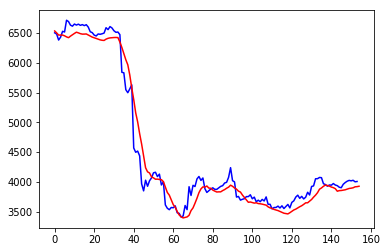

In [117]:
def prediction(time_step=2):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]],keep_prob:1})
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[2]+mean[2]
        test_predict=np.array(test_predict)*std[2]+mean[2]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)]) 
        #print("The accuracy of this predict:",acc)
        print(sqrt(mean_squared_error(test_y[:len(test_predict)],test_predict)))
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b',)
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()

prediction()